# DTSA 5510 Final Project
Nathan Hansen
### Introduction
For this project I chose a [dataset](https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package) describing weather in Australia, retrieved from Kaggle. The dataset covers about 10 years of daily weather observations from 49 weather stations across Australia. Each observation includes 23 features, such as date, location, temperature, humidity, etc.

Unsupervised clustering analysis will be performed to gain a better understanding of trends in the data.

All code for the project can be found at my GitHub: https://github.com/nhansendev/DTSA5510_Final

### Setup

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import os

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

# Some functions have been moved to a separate file for brevity
import functions

# Draw grid in background
plt.rcParams['axes.axisbelow'] = True

SCRIPT_DIR = os.getcwd()
RANDOM_SEED = 1

### Data Exploration and Cleaning
Loading and inspecting the dataset:

In [2]:
raw_data = pd.read_csv(os.path.join(SCRIPT_DIR, 'weatherAUS.csv'))
functions.inspect_df(raw_data)

Date         : (3436) ['2007-11-01', '2007-11-02', '2007-11-03', '2007-11-04', '2007-11-05'], [1, 1, 1, 1, 1] ... ['2017-06-21', '2017-06-22', '2017-06-23', '2017-06-24', '2017-06-25'], [49, 49, 49, 49, 48] | Missing: 0
Location     : (49) ['Adelaide', 'Albany', 'Albury', 'AliceSprings', 'BadgerysCreek'], [3193, 3040, 3040, 3040, 3009] ... ['Watsonia', 'Williamtown', 'Witchcliffe', 'Wollongong', 'Woomera'], [3009, 3009, 3009, 3040, 3009] | Missing: 0
MinTemp      : -8.500 to 33.900 | Missing: 1485
MaxTemp      : -4.800 to 48.100 | Missing: 1261
Rainfall     : 0.000 to 371.000 | Missing: 3261
Evaporation  : 0.000 to 145.000 | Missing: 62790
Sunshine     : 0.000 to 14.500 | Missing: 69835
WindGustDir  : (17) ['E', 'ENE', 'ESE', 'N', 'NE'], [9181, 8104, 7372, 9313, 7133] ... ['SW', 'W', 'WNW', 'WSW', 'nan'], [8967, 9915, 8252, 9069, 10326] | Missing: 10326
WindGustSpeed: 6.000 to 135.000 | Missing: 10263
WindDir9am   : (17) ['E', 'ENE', 'ESE', 'N', 'NE'], [9176, 7836, 7630, 11758, 7671] .

Clearly, some cleaning and data type conversions will be required:
1. Most features have at least one missing value (nan)
2. The ranges of each feature vary widely, requiring standardization
3. Values are a mix of binary, numeric, and categorical, and must all be converted to numeric representation (such as factorization for categorical)
4. There is a strong possibility of feature correlations, such as humidity, clouds, and rainfall

Let's get an idea of where this data is being collected by looking at the location of each weather station in the dataset:

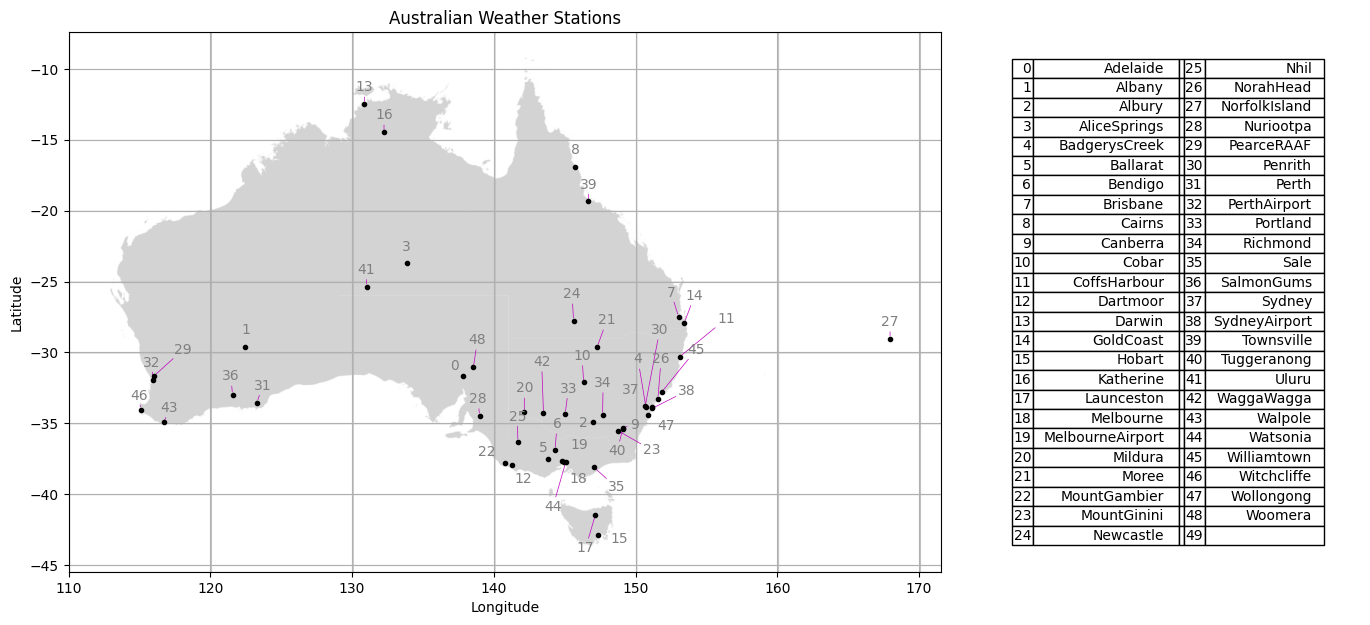

In [3]:
functions.plot_map(SCRIPT_DIR, raw_data)
plt.show()

We can see that there is a clear bias towards the south-east of the continent, with one outlier (a small island) on the far right. Multiple areas have several stations in very close proximity to each-other, in which case we could expect very similar measurements from those stations.

While it won't be explored in this analysis, it may make sense to cluster the stations by proximity if trying to make predictions. Norfolk Island in the middle of the ocean will probably have very different weather patterns than Alice Springs in the central desert region of the continent, for example.

### Numeric Data Sanity Check
We can perform a series of checks to determine whether the numeric values are within realistic ranges:
- **Temperature**: per the Australian government [1], the highest and lowest recorded temperatures in Australia were 50.7C and -23C, respectively. Our data range of 48.1C to -8.5C fits well within this range.

- **Rainfall**: also per [1], the average annual rainfall is 165mm, with the highest rainfall in a day at 907mm. Our high of 371mm in a day seems reasonable.

- **Evaporation**: per [2], the average annual evaporation (Class A Pan) ranges from 1000 to 4000mm across Australia, so our high of 1740mm annually (based on 145mm per month) seems reasonable.

- **Sunshine**: per [3], the annual average daily sunshine hours across Australia range from 5 to 10 hours, so the range of 0 to 14.5 hours per day in our data seems reasonable.

- **Wind Speed**: per [4], the average monthly wind velocity ranges as high as approx. 40kph, though our data (averaged in 10 minute intervals) shows a range up to 130kph. Since this is several times higher than the average it suggests that there may be outliers, though [5] confirms that during storms the gusts may reach speeds exceeding 160kph, so the speeds in our dataset are at least possible.

- **Humidity**: The data range is 0-100%, which is feasible in-general for a country with varying climate zones like Australia.

- **Pressure**: per [6], daily forecast can be found with average sea-level air pressure ranges from 995 to 1027hpa, which is similar to the range of our data.

- **Cloud**: units are measured in "oktas", which per [7] are a unit of measurement proportional to the cloud cover in the sky, with 0-8 being the normal range of clear to fully overcast and 9 representing that the sky is "obstructed from view". This matches our data range, but we may need to treat values at 9 differently since they don't match the progression of the scale.

- **Rain Frequency**: also per [1], the most frequent rainfall in one part of Australia is 237 days/year on average, or about 65% of the year. Comparing the ratio of "Yes" and "No" for RainToday we get about 22% of days with rainfall, well within the max.

### Cloud Cover
As mentioned above, the cloud cover units are inconsistent, with 0-8 being proportional to the amount of cloud cover, and 9 representing an obstructed view of the sky. Effectively this indicates a missing value. Checking the count of these occurrences reveals a total of three in the entire dataset, indicating that they can simply be dropped.

In [4]:
print(np.sum(raw_data['Cloud3pm'] == 9))
print(np.sum(raw_data['Cloud9am'] == 9))

raw_data = raw_data[raw_data['Cloud3pm'] != 9]
raw_data = raw_data[raw_data['Cloud9am'] != 9]

1
2



##### Handling Missing Values
Next, let's look at the number of missing values per row:

Keep: 142340, Remove: 3117 (2.2%)


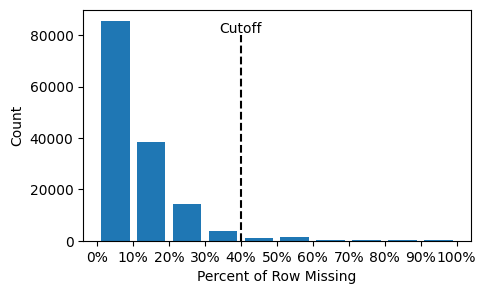

In [5]:
N = raw_data.shape[1]
all_nan = np.sum(raw_data.astype(str) == 'nan', 1)/23
cutoff = 0.4
idxs = all_nan < cutoff
K = np.sum(idxs)
R = np.sum(np.invert(idxs))
print(f'Keep: {K}, Remove: {R} ({R/K:.1%})')
reduced_data = raw_data[idxs]

bins = np.arange(0, 1.1, 0.1)
plt.hist(all_nan, bins=bins, rwidth=0.8)
plt.gcf().set_size_inches(5, 3)
plt.vlines(cutoff, 0, 80000, linestyles='--', colors='k')
plt.text(cutoff, 80000, 'Cutoff', ha='center', va='bottom')
plt.xticks(bins, [f'{x:.0%}' for x in bins])
plt.xlabel('Percent of Row Missing')
plt.ylabel('Count')
plt.show()

From the histogram we can see that while some outlier rows are missing 90-100% of their data, most have less than 40%-50% missing. Since rows with a large amount of missing information would be difficult to impute meaningfully they will be dropped instead, with the cutoff set at 40% missing. This represents only a small fraction of the total dataset (2.2%), so there is mininal concern about skewing the data, or decreasing the amount of available data for training.

We can attempt to fill-in the remaining missing values via the sklearn K-Nearest Neighbors Imputer (KNNImputer), but it requires that we first convert all values to a numeric representation so that distances can be calculated. Dates will be converted to the day of the year (e.g. January 7th becomes 7) and categories will be factorized (e.g. "A", "B", "C", ... becomes 0, 1, 2, ...). The "nan" values will be retained, since they are required for the imputer.

In [6]:
# Convert date and category to numeric
numeric_data = reduced_data.copy(deep=True)

# Date to day of year
numeric_data['Date'] = pd.to_datetime(numeric_data['Date'])
numeric_data['Date'] = numeric_data['Date'].dt.dayofyear
numeric_data.rename(columns={'Date': "Day"}, inplace=True)

# Map station locations to values in alphabetical order
locmap = {k: i for i, k in enumerate(np.unique(numeric_data['Location']))}
for k, i in locmap.items():
    numeric_data.loc[numeric_data['Location']==k, 'Location'] = i

# Categories to integers, retaining missing values as nan
for c in ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']:
    numeric_data[c] = pd.factorize(numeric_data[c])[0]
    # Keep track of the nan values, which are factorized to -1
    numeric_data.loc[numeric_data[c] == -1, c] = np.nan
    
numeric_data

,Day,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,336,2,13.4,22.9,0.6,NaN,NaN,0.0,44.0,0.0,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,0.0,0.0
1,337,2,7.4,25.1,0.0,NaN,NaN,1.0,44.0,1.0,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,0.0,0.0
2,338,2,12.9,25.7,0.0,NaN,NaN,2.0,46.0,0.0,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,0.0,0.0
3,339,2,9.2,28.0,0.0,NaN,NaN,3.0,24.0,2.0,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,0.0,0.0
4,340,2,17.5,32.3,1.0,NaN,NaN,0.0,41.0,3.0,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,172,41,2.8,23.4,0.0,NaN,NaN,14.0,31.0,2.0,...,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,0.0,0.0
145456,173,41,3.6,25.3,0.0,NaN,NaN,4.0,22.0,2.0,...,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,0.0,0.0
145457,174,41,5.4,26.9,0.0,NaN,NaN,5.0,37.0,2.0,...,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,0.0,0.0
145458,175,41,7.8,27.0,0.0,NaN,NaN,12.0,28.0,5.0,...,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,0.0,0.0


In [7]:
# This cell takes ~12 min to run
imputed_data = KNNImputer(n_neighbors=3).fit_transform(numeric_data)
imputed_data = pd.DataFrame(imputed_data, columns=numeric_data.columns)
# Clean-up booleans
imputed_data['RainTomorrow'] = (imputed_data['RainTomorrow']>0.5).astype('float')
imputed_data['RainToday'] = (imputed_data['RainToday']>0.5).astype('float')
functions.inspect_df(imputed_data)

Day          : 1.000 to 366.000 | Missing: 0
Location     : 0.000 to 48.000 | Missing: 0
MinTemp      : -8.500 to 33.900 | Missing: 0
MaxTemp      : -4.800 to 48.100 | Missing: 0
Rainfall     : 0.000 to 371.000 | Missing: 0
Evaporation  : 0.000 to 145.000 | Missing: 0
Sunshine     : 0.000 to 14.500 | Missing: 0
WindGustDir  : 0.000 to 15.000 | Missing: 0
WindGustSpeed: 6.000 to 135.000 | Missing: 0
WindDir9am   : 0.000 to 15.000 | Missing: 0
WindDir3pm   : 0.000 to 15.000 | Missing: 0
WindSpeed9am : 0.000 to 87.000 | Missing: 0
WindSpeed3pm : 0.000 to 87.000 | Missing: 0
Humidity9am  : 0.000 to 100.000 | Missing: 0
Humidity3pm  : 0.000 to 100.000 | Missing: 0
Pressure9am  : 980.500 to 1041.000 | Missing: 0
Pressure3pm  : 977.100 to 1039.600 | Missing: 0
Cloud9am     : 0.000 to 8.000 | Missing: 0
Cloud3pm     : 0.000 to 8.000 | Missing: 0
Temp9am      : -7.200 to 40.200 | Missing: 0
Temp3pm      : -5.400 to 46.700 | Missing: 0
RainToday    : 0.000 to 1.000 | Missing: 0
RainTomorrow : 0.

As expected, no missing values remain after imputation.

To compare before and after imputation is performed, a histogram of each feature is plotted:

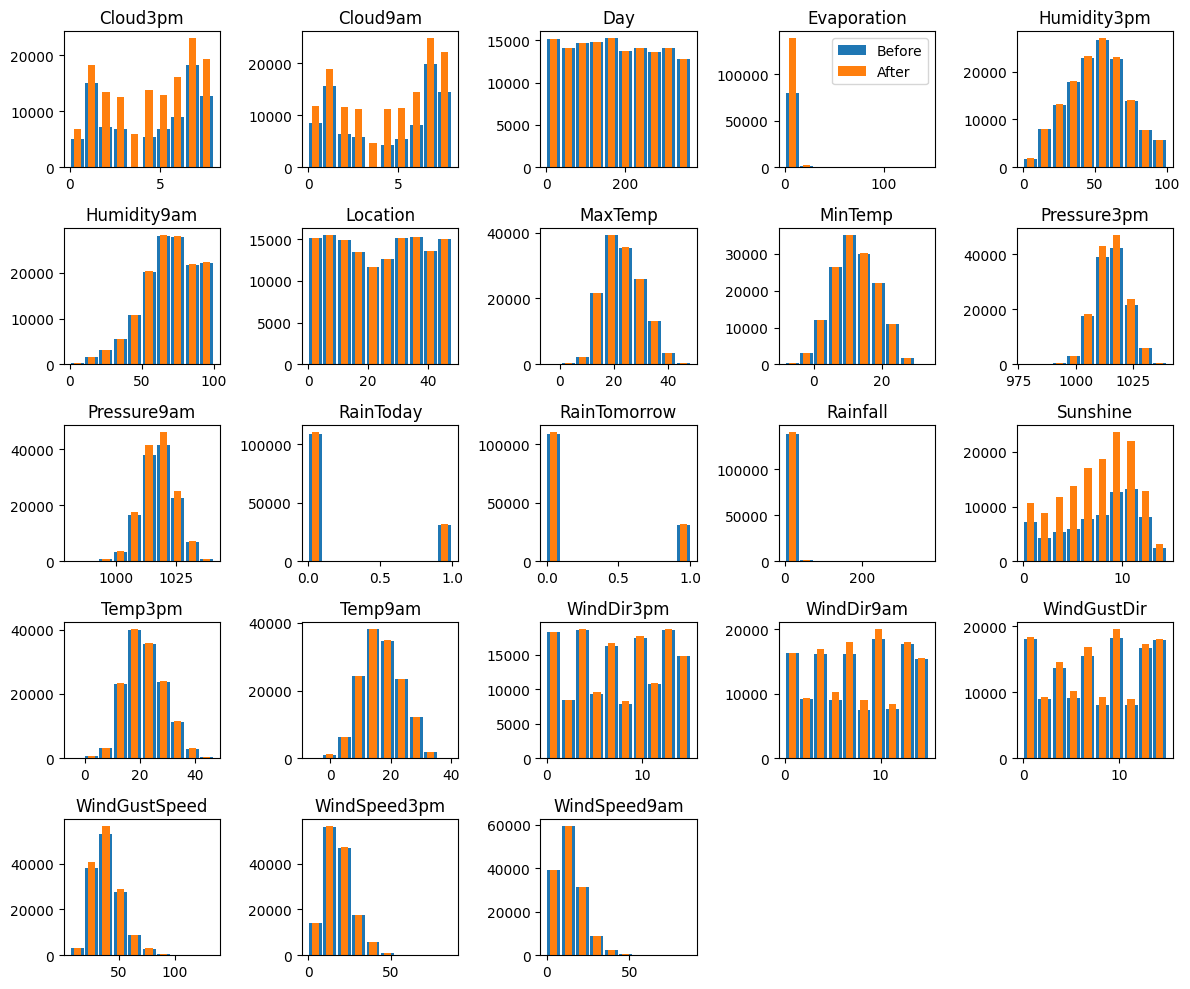

In [22]:
hist_bins = functions.plot_hist(numeric_data, imputed_data, legend_idx=3)

We can see that the KNNImputer has done an excellent job of matching the original data distributions. Recall that some features had many (up to 70k) missing values and others had none, so the number of changes are not consistent across features.

Some observations about the distributions:
1. Many are heavily skewed by outliers, such as Rainfall, Evaporation, and Wind Speeds
2. Days and locations are approximately uniformly distributed, which is expected
3. Most distributions are roughly normal
4. Wind directions exhibit strange, but consistent patterns, which are most likely caused by an inconsistency in how wind direction is measured. Per [8], "Eight directions are used.", but there are clearly 16 unique directions in the data.
5. Cloud coverage has clusters near the high and low ends of the range (mostly clear and mostly overcast). Per [8], cloud cover is estimated visually, where "The presence of any trace of cloud in an otherwise blue sky is recorded as 1 okta, and similarly any trace of blue in an otherwise cloudy sky is recorded as 7 oktas.". This subjective measurement method could easily result in a biased distribution, and seems like a resonable explanation for what is seen here. 

### Addressing Outliers
Standardizing the dataset can aid in later analysis and clarify which features have significant outliers.

In [9]:
# Create standardized dataset
std_data = imputed_data.copy(deep=True)
columns = std_data.columns
std_data[columns] = StandardScaler().fit_transform(std_data[columns].values)

functions.inspect_df(std_data)
print(std_data.shape)

Day          : -1.704 to 1.782 | Missing: 0
Location     : -1.667 to 1.686 | Missing: 0
MinTemp      : -3.242 to 3.395 | Missing: 0
MaxTemp      : -3.952 to 3.502 | Missing: 0
Rainfall     : -0.280 to 43.923 | Missing: 0
Evaporation  : -1.362 to 36.189 | Missing: 0
Sunshine     : -2.095 to 1.991 | Missing: 0
WindGustDir  : -1.642 to 1.618 | Missing: 0
WindGustSpeed: -2.504 to 7.048 | Missing: 0
WindDir9am   : -1.664 to 1.683 | Missing: 0
WindDir3pm   : -1.625 to 1.662 | Missing: 0
WindSpeed9am : -1.584 to 8.220 | Missing: 0
WindSpeed3pm : -2.121 to 7.773 | Missing: 0
Humidity9am  : -3.618 to 1.634 | Missing: 0
Humidity3pm  : -2.484 to 2.337 | Missing: 0
Pressure9am  : -5.307 to 3.319 | Missing: 0
Pressure3pm  : -5.517 to 3.502 | Missing: 0
Cloud9am     : -1.674 to 1.339 | Missing: 0
Cloud3pm     : -1.804 to 1.420 | Missing: 0
Temp9am      : -3.723 to 3.575 | Missing: 0
Temp3pm      : -3.905 to 3.593 | Missing: 0
RainToday    : -0.537 to 1.861 | Missing: 0
RainTomorrow : -0.536 to 1.864

It is clear from the summary that several feature have large outliers (e.g. Rainfall at 43.9 standard deviations from the mean).

However, because Australia is host to many climates these outliers might just be caused by a few locations in "extreme" climates (e.g. dense rainforests, islands, etc.). To explore this idea the data is plotted by location, with each mean and standard deviation calculated separately:

Avg Rainfall: 2.35 mm


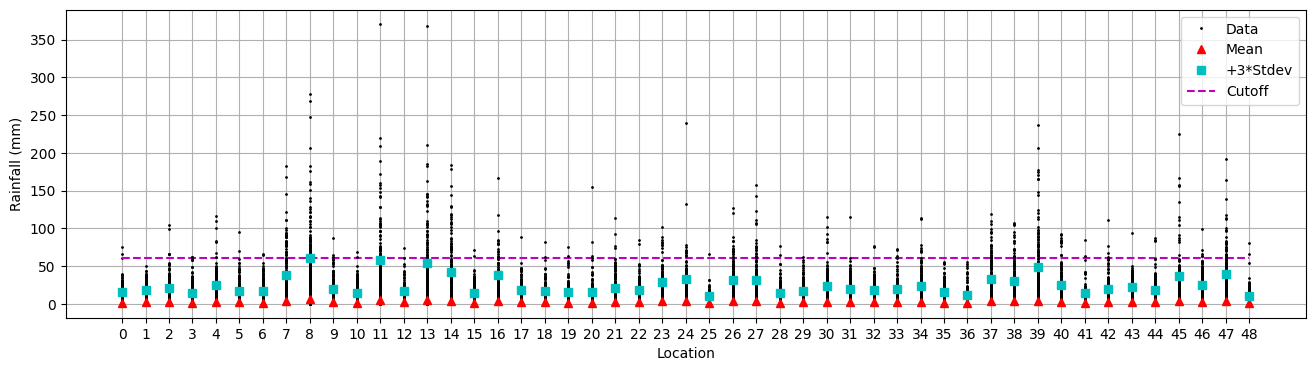

In [10]:
vals = []
fname = 'Rainfall'
for i in range(49):
    tmp = imputed_data[fname][imputed_data['Location']==i]
    vals.append(tmp)

std = np.std(imputed_data[fname])
mean = np.mean(imputed_data[fname])
print(f'Avg Rainfall: {mean:.2f} mm')

for i, v in enumerate(vals):
    plt.plot([i]*len(v), v, '.', color='k', markersize=2)
    plt.plot(i, np.mean(v), 'r^')
    plt.plot(i, np.mean(v)+np.std(v)*3, 'cs')
    if i == 0:
        plt.hlines(mean+7*std, 0, 48, linestyles='dashed', color='m')

plt.legend(['Data', 'Mean', '+3*Stdev', 'Cutoff'])

plt.gcf().set_size_inches(16, 4)
plt.grid()
plt.xticks(range(49))
plt.xlabel('Location')
plt.ylabel("Rainfall (mm)")
plt.show()


From the plot it's clear that while all of the averages are small compared to the range of the data, the distributions can still have large differences by location. To remove the outliers while retaining the bulk of each distribution, a cutoff of seven standard deviations from the global mean was chosen. This is the smallest value that would encompass three standard deviations from each mean. All values above this will simply be dropped.

This cutoff is applied to each feature, resulting in a "trimmed" dataset:

In [11]:
idxs = np.abs(std_data)>7
std_data[idxs] = np.nan
std_data.dropna(inplace=True)

trimmed_data = imputed_data.copy(deep=True)
trimmed_data[idxs] = np.nan
trimmed_data.dropna(inplace=True)

functions.inspect_df(std_data)
print(std_data.shape)

print(f"{imputed_data.shape} -> {trimmed_data.shape} ({trimmed_data.shape[0]/imputed_data.shape[0]-1:.1%})")

Day          : -1.704 to 1.782 | Missing: 0
Location     : -1.667 to 1.686 | Missing: 0
MinTemp      : -3.242 to 3.395 | Missing: 0
MaxTemp      : -3.952 to 3.502 | Missing: 0
Rainfall     : -0.280 to 6.988 | Missing: 0
Evaporation  : -1.362 to 6.977 | Missing: 0
Sunshine     : -2.095 to 1.991 | Missing: 0
WindGustDir  : -1.642 to 1.618 | Missing: 0
WindGustSpeed: -2.504 to 6.677 | Missing: 0
WindDir9am   : -1.664 to 1.683 | Missing: 0
WindDir3pm   : -1.625 to 1.662 | Missing: 0
WindSpeed9am : -1.584 to 6.755 | Missing: 0
WindSpeed3pm : -2.121 to 6.749 | Missing: 0
Humidity9am  : -3.618 to 1.634 | Missing: 0
Humidity3pm  : -2.484 to 2.337 | Missing: 0
Pressure9am  : -5.307 to 3.319 | Missing: 0
Pressure3pm  : -5.517 to 3.502 | Missing: 0
Cloud9am     : -1.674 to 1.339 | Missing: 0
Cloud3pm     : -1.804 to 1.420 | Missing: 0
Temp9am      : -3.723 to 3.575 | Missing: 0
Temp3pm      : -3.905 to 3.593 | Missing: 0
RainToday    : -0.537 to 1.861 | Missing: 0
RainTomorrow : -0.536 to 1.864 |

This resulted in just a 0.5% reduction in data.

### Correlation
It's highly likely that datapoints gathered on the same day would be correlated across locations and times. For example, a day in the summer will have higher min and max temperatures than a day in the winter. A day without storms will tend to have relatively stable air pressure, etc. A correlation matrix is plotted below to explore this idea.

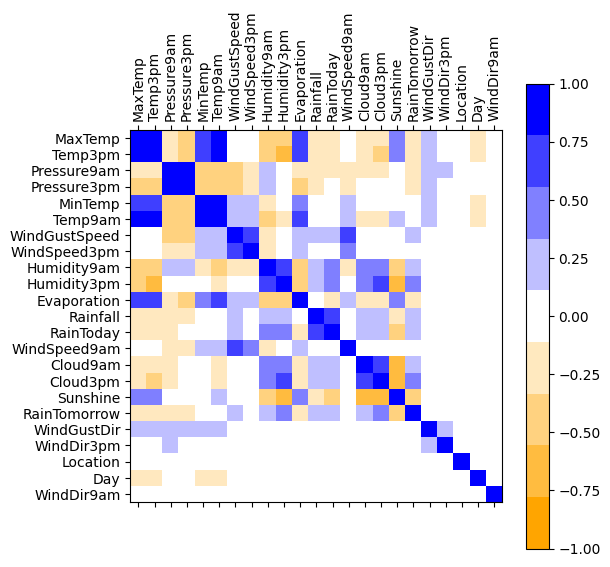

In [12]:
cmap = LinearSegmentedColormap.from_list('custom', ['orange', 'white', 'blue'], N=9)

# Plot a correlation matrix, sorted by highest correlations
correlations = trimmed_data.corr()
correlations -= np.eye(correlations.shape[0])
pairs = list(zip(np.max(correlations, 1), trimmed_data.columns))
pairs.sort(key=lambda x: abs(x[0]), reverse=True)
col_order = [p[1] for p in pairs]
correlations = trimmed_data[col_order].corr()

plt.matshow(correlations, cmap=cmap, vmin=-1, vmax=1)
plt.xticks(ticks=range(len(col_order)), labels=col_order, rotation=90)
plt.yticks(ticks=range(len(col_order)), labels=col_order)
plt.colorbar()
plt.gcf().set_size_inches(6, 6)
plt.show()

As expected, several features are highly correlated, or inversely correlated. For example, the max temperature of the day and the temperature measured at 3pm, which tends to be near the hottest part of the day. High temperatures encourage evaporation and they are seen to be highly correlated. Nothing stands-out as unexpected.

To determine how much correlation is too much the Variance Inflation Factors (VIFs) are calculated.

In [13]:
VIFs = np.linalg.inv(correlations.values).diagonal()
print()
print(pd.DataFrame(VIFs, index=col_order, columns=['VIF']).round(2))


                 VIF
MaxTemp        44.35
Temp3pm        51.28
Pressure9am    20.40
Pressure3pm    19.99
MinTemp         9.57
Temp9am        22.53
WindGustSpeed   2.96
WindSpeed3pm    2.16
Humidity9am     4.25
Humidity3pm     6.74
Evaporation     2.23
Rainfall        1.68
RainToday       1.90
WindSpeed9am    1.90
Cloud9am        2.12
Cloud3pm        2.15
Sunshine        3.10
RainTomorrow    1.50
WindGustDir     1.10
WindDir3pm      1.07
Location        1.03
Day             1.15
WindDir9am      1.02


A threshold of 8 will be used to determine which variables have too high of a VIF.

These three features with high VIFs will be removed, with their correlated counterpart retained:
- Temp3pm 
- Pressure9am
- Temp9am

In [30]:
col_order_reduced = [c for c in col_order if c not in ['Temp3pm', 'Pressure9am', 'Temp9am']]
correlations = trimmed_data[col_order_reduced].corr()
VIFs = np.linalg.inv(correlations.values).diagonal()

print(pd.DataFrame(VIFs, index=col_order_reduced, columns=['VIF']).round(2))

prepared_data = trimmed_data[col_order_reduced]
prepared_std_data = std_data[col_order_reduced]

                VIF
MaxTemp        6.76
Pressure3pm    1.74
MinTemp        4.85
WindGustSpeed  2.85
WindSpeed3pm   2.09
Humidity9am    2.69
Humidity3pm    4.07
Evaporation    2.17
Rainfall       1.67
RainToday      1.87
WindSpeed9am   1.88
Cloud9am       2.10
Cloud3pm       2.13
Sunshine       3.07
RainTomorrow   1.48
WindGustDir    1.10
WindDir3pm     1.05
Location       1.03
Day            1.11
WindDir9am     1.02


##### Geographical Check
Plotting feature averages by their observation location on the map can help us understand their geographic distribution. For example, by plotting the average max temperature for each station we can see a clear correlation with latitude. This makes sense, since the average temperature is expected to decrease as distance from the equator increases:

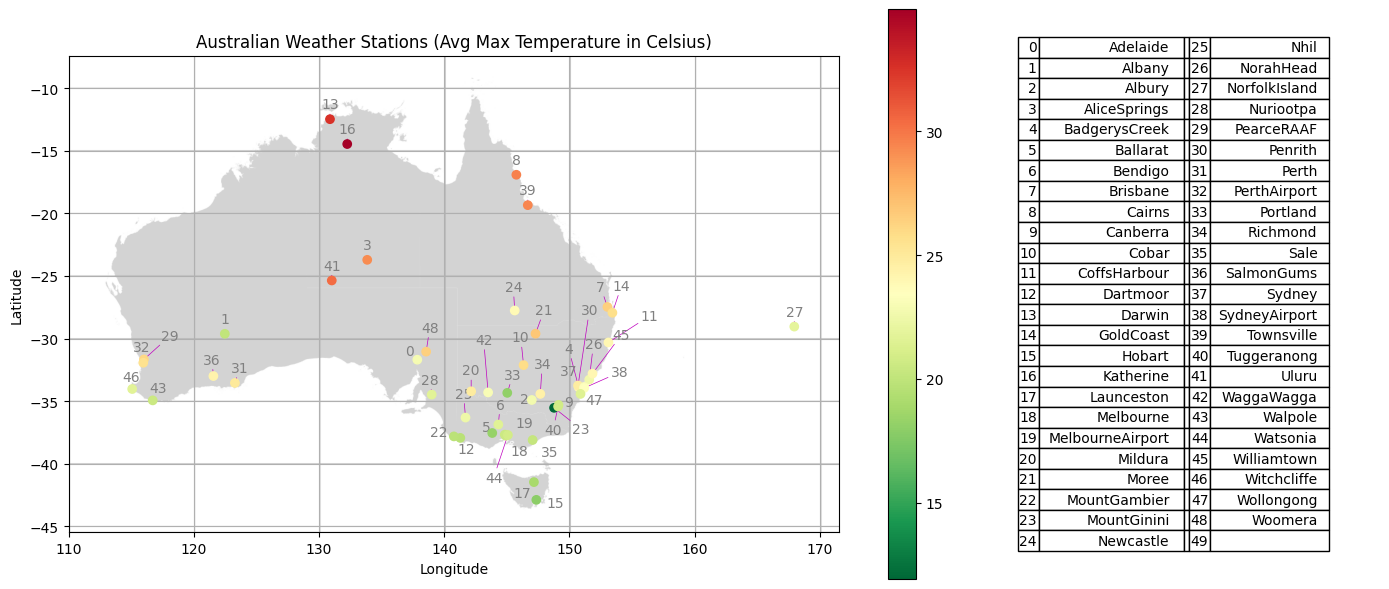

In [15]:
fig, axs, locs, xlims, ylims = functions.plot_map(SCRIPT_DIR, raw_data, title="Australian Weather Stations (Avg Max Temperature in Celsius)")

vals = []
fname = 'MaxTemp'
for i in range(49):
    tmp = prepared_data[fname][prepared_data['Location']==i]
    vals.append(tmp)

avgs = []
for i, v in enumerate(vals):
    avgs.append(np.mean(v))
sctr = axs[0].scatter(locs['Lon'], locs['Lat'], c=avgs, cmap='RdYlGn_r', zorder=5)
plt.colorbar(sctr, ax=axs[0])
plt.tight_layout()
plt.show()

We can see that #23 (Mount Ginini) has an unusually low average, which can be explained by its high altitude (1762 m / 5781 ft above sea-level). Unlike Mount Ginini, the weather station at Mount Gambier is only approximately 60 m (197 ft) above sea-level, so it makes sense that its average matches the locations nearby.

### Data Modeling
Now that the data has been prepared we can use clustering algorithms and dimensionality reduction to explore relationships between features.

It may be possible to differentiate weather station locations around the country by their typical weather conditions (e.g. less rain and higher temperatures in a desert region). To evaluate this idea the data will be clustered via KMeans, which will assign a category to each observation. The most frequent observation category for a given location will determine its final cluster assignment.

In [16]:
tmp = prepared_std_data.drop(columns=['Location'])
alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

N = 2
kmodel = KMeans(N, random_state=RANDOM_SEED).fit(tmp)
clusters = kmodel.labels_

values, counts = np.unique(clusters, return_counts=True)
N = len(values)
print(pd.DataFrame(counts, index=[alphabet[v] for v in values], columns=['Count']))

values, counts = np.unique(prepared_data['Location'], return_counts=True)
pairs = {k: [] for k in values} 
for i, L in enumerate(values):
    # Fraction of location L in cluster i
    for j in range(N):
        pairs[L].append(np.sum(np.logical_and(clusters==j, prepared_data['Location']==L))/counts[i])

# Which cluster is each location assigned to most often?
probs = np.array(list(pairs.values()))
nearest = np.argmax(probs, 1)
nearest[np.max(np.abs(probs-1/N), 1)<0.05] = -1

loc_cluster_df = pd.DataFrame(pairs, index=[alphabet[v] for v in range(N)]).T
print(loc_cluster_df.head())

# print(nearest)

   Count
A  73011
B  68612
            A         B
0.0  0.591252  0.408748
1.0  0.296435  0.703565
2.0  0.486272  0.513728
3.0  0.885610  0.114390
4.0  0.488309  0.511691


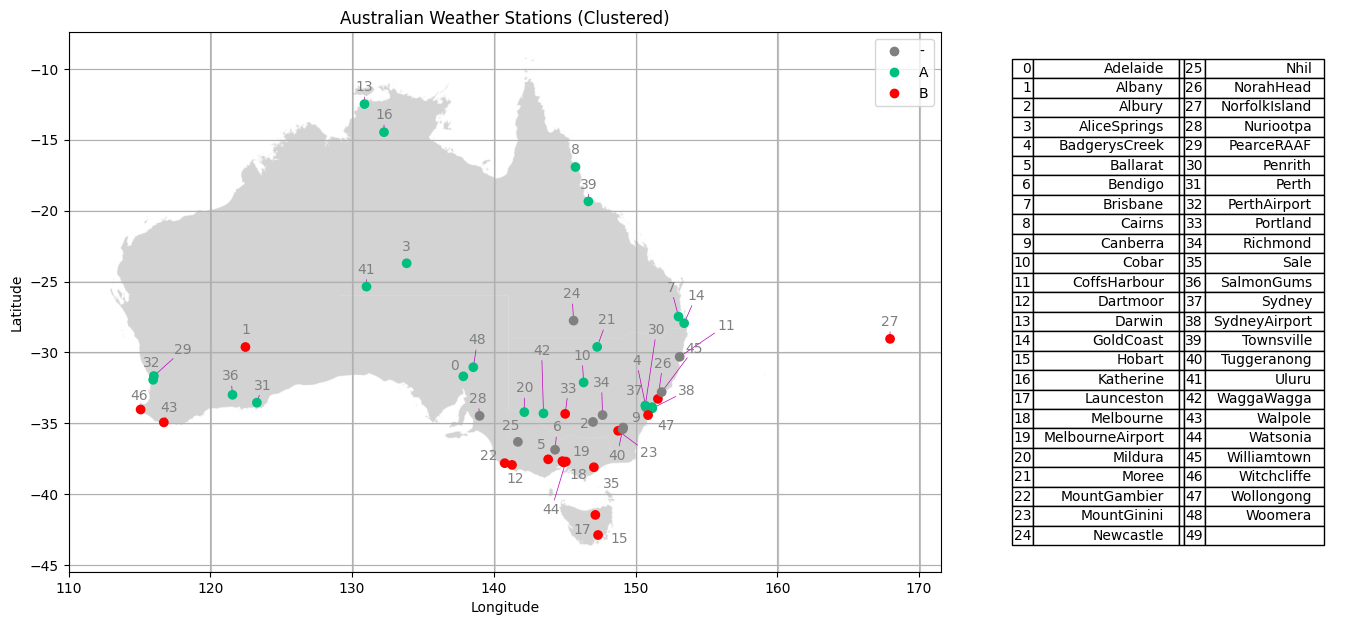

In [17]:
# Color locations on the map by clustered weather observations
fig, axs, locs, xlims, ylims = functions.plot_map(SCRIPT_DIR, raw_data, title='Australian Weather Stations (Clustered)')

cmap = LinearSegmentedColormap.from_list("", ['gray', 'cyan', 'green', 'red'])
sctr = axs[0].scatter(locs["Lon"], locs["Lat"], c=nearest, zorder=5, cmap=cmap)
axs[0].legend(handles=sctr.legend_elements()[0], labels=['-']+[alphabet[v] for v in range(N)])
plt.show()

From the map we can see the result of fitting the locations to two clusters, with a third (shown in gray, label "-") representing "indecision" where there was an approximate tie between each cluster choice (within +/-5%). We can see that the cluster assignments have a rough correlation with latitude, with the groups roughly divisible by horizontal lines. The indecisive points appear near the boundary between the clusters.

As we saw eariler, maximum temperature was clearly correlated with latidute, and had strong correlations/inverse correlations with many other variables. It makes sense then, that the KMeans clustering would produce a distribution that reflects the max temperature distribution.

We can compare the data in each cluster by plotting their histograms:

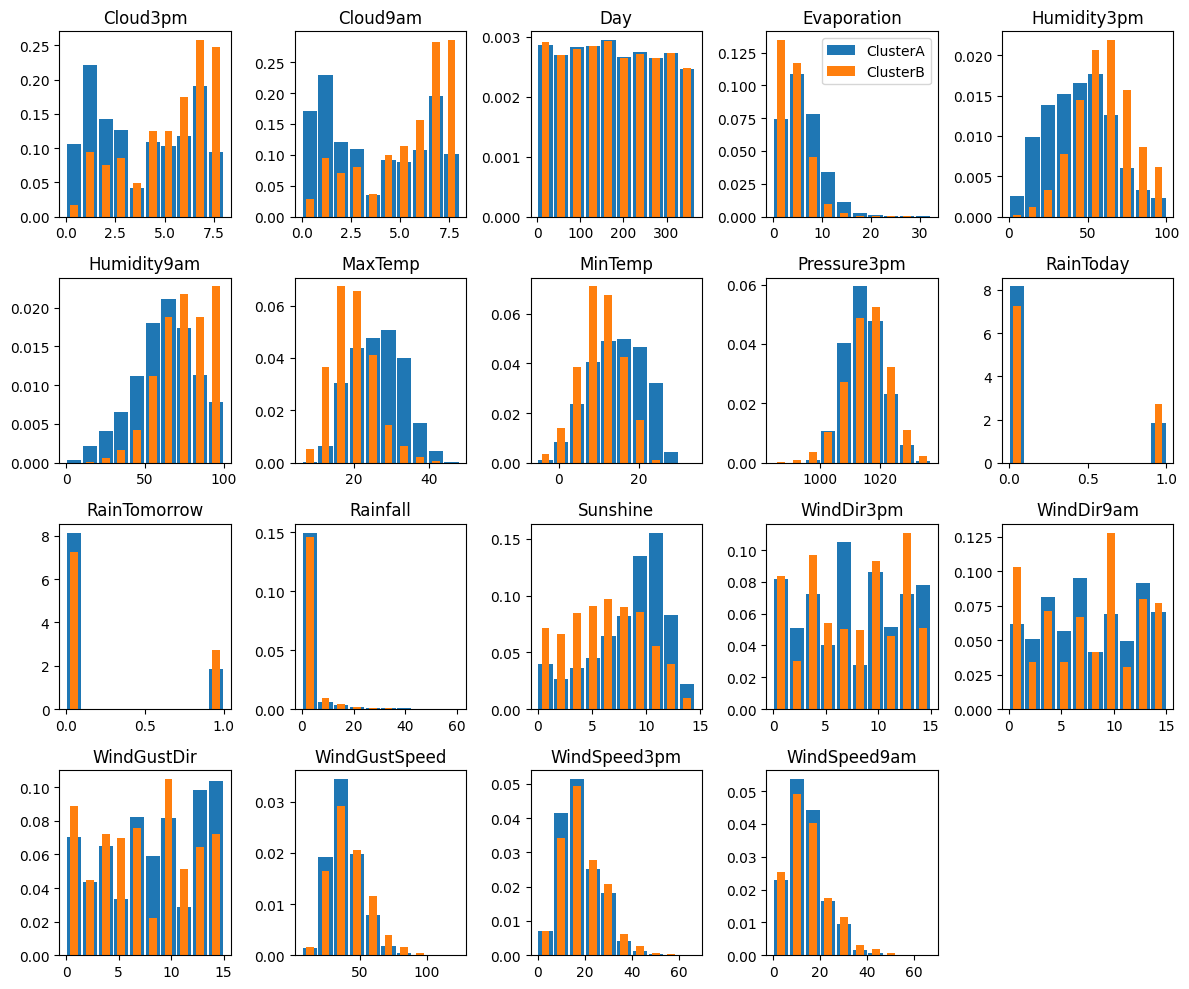

In [38]:
# Add a column to track the cluster assignment of each observation
prepared_data.insert(0, 'Nearest', 0)
for i, n in enumerate(nearest):
    prepared_data.loc[prepared_data['Location']==i, 'Nearest'] = n

# Compare histograms of each cluster
cluster_A = prepared_data[prepared_data['Nearest'] == 0].drop(columns=['Nearest', 'Location'])
cluster_B = prepared_data[prepared_data['Nearest'] == 1].drop(columns=['Nearest', 'Location'])
functions.plot_hist(cluster_A, cluster_B, legend=['ClusterA', 'ClusterB'], nrows=4, legend_idx=3, density=True);

In cluster B: cloud cover is biased towards overcast, max and min temperature are lower, there is less sunshine, and higher humidity. This makes sense, since most of the northern region of Australia where group A is has a desert climate. If we were attempting to predict weather patterns it may make sense to use these cluster to generate two specialized models instead of one "global" model.

##### Dimensionality Reduction
Here, Principle Component Analysis (PCA) is used to linearly map the 20-dimensional standardized dataset to a 2-dimensional representation, which allows it to be plotted at the expense of ~61% lost information (based on the explained variance):

In [41]:
# Map data to two dimensions
pca_model = PCA(2, random_state=RANDOM_SEED).fit(prepared_std_data)
pca_fit = pca_model.transform(prepared_std_data)

print(f'Explained Variance: {sum(pca_model.explained_variance_ratio_):.1%}')

Explained Variance: 39.0%


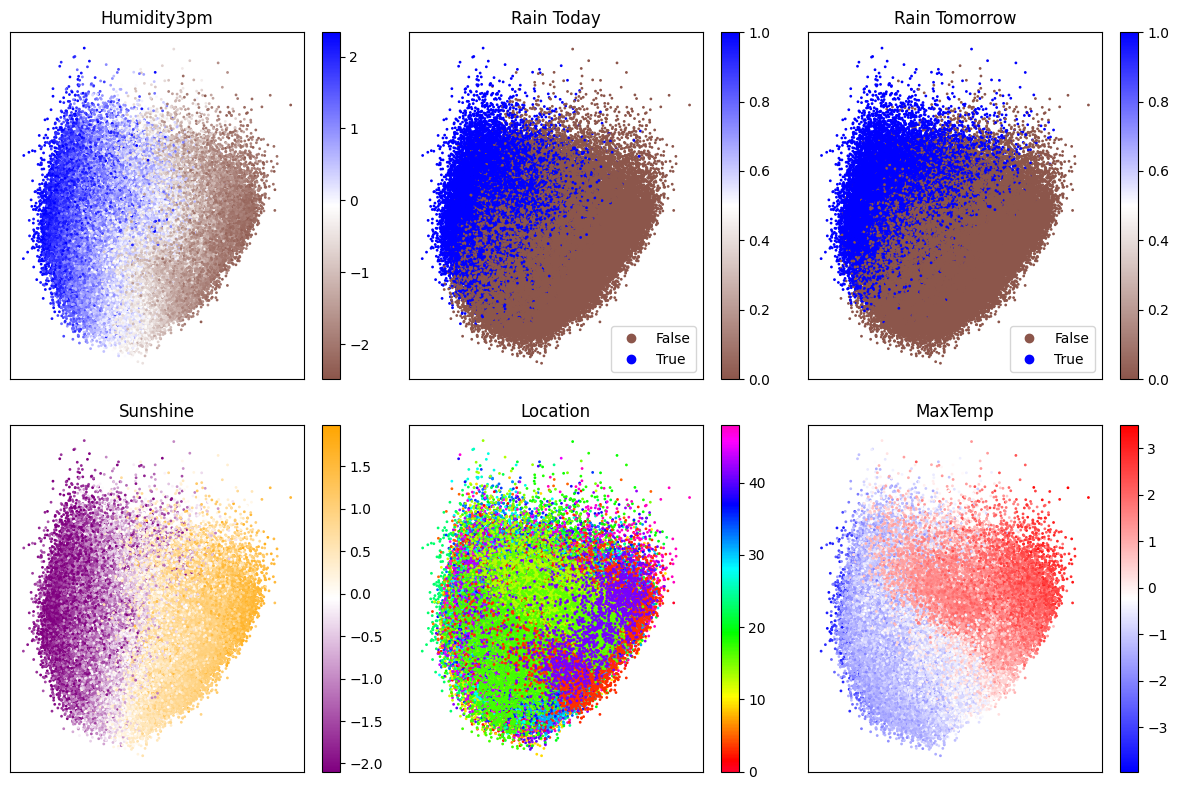

In [42]:
fig, ax = plt.subplots(2, 3)
axs = fig.axes
fig.set_size_inches(12, 8)

alpha = 1
size = 1
X, Y = pca_fit.T
cmap = LinearSegmentedColormap.from_list("", ['tab:brown', 'white', 'blue'])
pts = axs[0].scatter(X, Y, c=prepared_std_data['Humidity3pm'], s=size, alpha=alpha, cmap=cmap)
axs[0].set_title('Humidity3pm')
plt.colorbar(pts)

pts = axs[1].scatter(X, Y, c=prepared_std_data['RainToday']>0, s=size, alpha=alpha, cmap=cmap)
axs[1].set_title('Rain Today')
axs[1].legend(handles=pts.legend_elements()[0], labels=['False', 'True'])
plt.colorbar(pts)

pts = axs[2].scatter(X, Y, c=prepared_std_data['RainTomorrow']>0, s=size, alpha=alpha, cmap=cmap)
axs[2].set_title('Rain Tomorrow')
axs[2].legend(handles=pts.legend_elements()[0], labels=['False', 'True'])
plt.colorbar(pts)

cmap = LinearSegmentedColormap.from_list("", ['purple', 'white', 'orange'])
pts = axs[3].scatter(X, Y, c=prepared_std_data['Sunshine'], s=size, alpha=alpha, cmap=cmap)
axs[3].set_title('Sunshine')
plt.colorbar(pts)

pts = axs[4].scatter(X, Y, c=prepared_data['Location'], s=size, alpha=alpha, cmap='gist_rainbow')
axs[4].set_title('Location')
plt.colorbar(pts)

pts = axs[5].scatter(X, Y, c=prepared_std_data['MaxTemp'], s=size, alpha=alpha, cmap='bwr')
axs[5].set_title('MaxTemp')
plt.colorbar(pts)

for a in axs:
    a.tick_params(axis='both', labelbottom=False, labelleft=False, bottom=False, left=False)

plt.tight_layout()
plt.show()

From the plots we can see an intuitive representation of the relationships revealed by the correlation matrix, such as the positive correlation between rain and humidity, a negative correlation between rain and sunshine, and the strong correlation between rain today and rain tomorrow. Features with similar patterns of high and low regions tend to have high correlation (positive or negative). We can only see rough relationships between features, which is a consquence of the data loss from restricting PCA to two components.

Note that the values for "Location" are just numeric labels for the weather station names, so a given color represents one of the 49 stations. It can be difficult to differentiate the locations, but there is clearly some clustering occurring, which is expected for locations with consistent weather patterns.

##### TSNE
Another method that can be used to project from higher to lower dimensions is T-distributed Stochastic Neighbor Embedding (TSNE) [9], which is non-linear and has the benefit of retaining more information, but at the cost of longer training time due to a more complex process. TSNE works by converting similarities between data points to probability distributions in the low-dimensional embedded space and the high-dimensional input data. The probabilities represent how likely each point is to pick another point as its neighbor, and by finding distributions in the low-dimensional space that are similar to their high-dimensional counterparts (via minimization of their Kullback-Leibler divergence) the datapoints can be rearranged into a low-dimensional representation. Roughly: the "distances" between points in higher dimensions are mapped into lower dimensions. It's also important to note that this algorithm is "non-convex", indicating that the final arrangement of points depends on the initial conditions.

In [43]:
# This cell takes ~21 min to run
tsne_fit = TSNE(random_state=RANDOM_SEED).fit_transform(prepared_std_data)

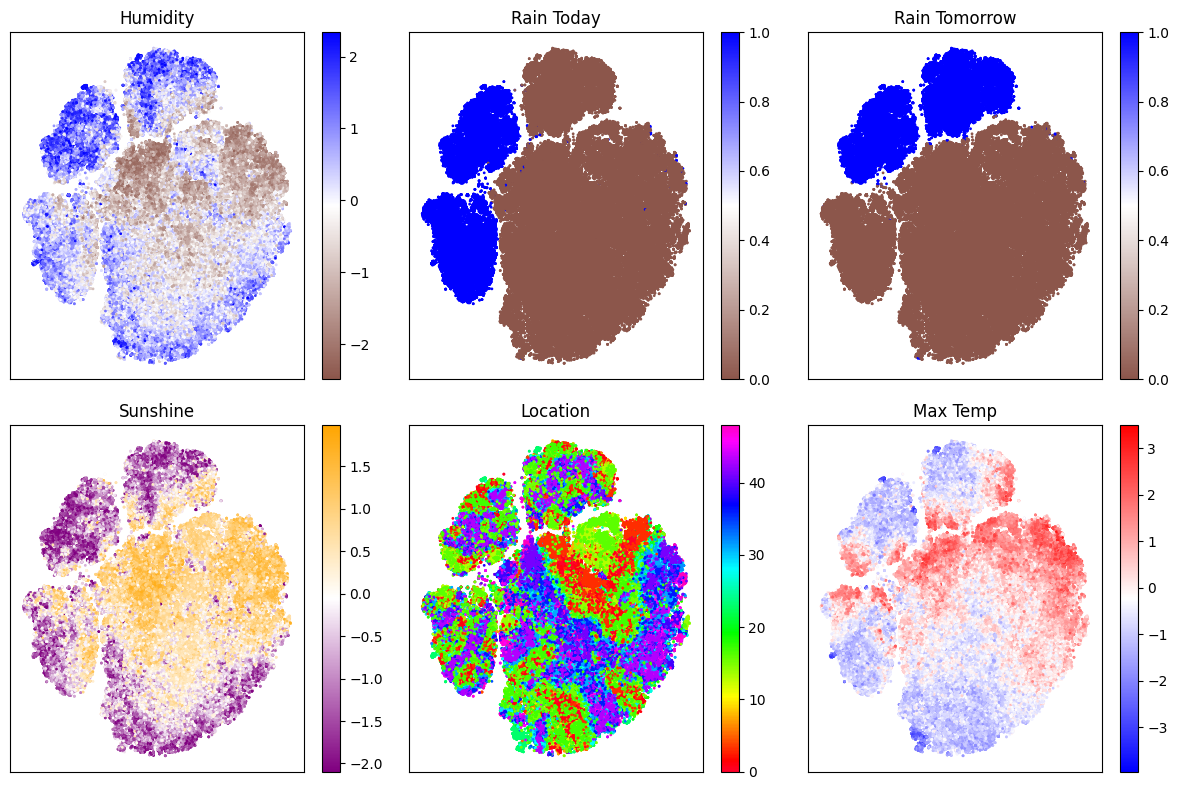

In [44]:
fig, ax = plt.subplots(2, 3)
axs = fig.axes
fig.set_size_inches(12, 8)

cmap = LinearSegmentedColormap.from_list("", ['tab:brown', 'white', 'blue'])
sctr = axs[0].scatter(*tsne_fit.T, c=prepared_std_data['Humidity3pm'], s=1, cmap=cmap)
axs[0].set_title('Humidity')
plt.colorbar(sctr)

sctr = axs[1].scatter(*tsne_fit.T, c=prepared_std_data['RainToday']>0, s=1, cmap=cmap)
axs[1].set_title('Rain Today')
plt.colorbar(sctr)

sctr = axs[2].scatter(*tsne_fit.T, c=prepared_std_data['RainTomorrow']>0, s=1, cmap=cmap)
axs[2].set_title('Rain Tomorrow')
plt.colorbar(sctr)

cmap = LinearSegmentedColormap.from_list("", ['purple', 'white', 'orange'])
sctr = axs[3].scatter(*tsne_fit.T, c=prepared_std_data['Sunshine'], s=1, cmap=cmap)
axs[3].set_title('Sunshine')
plt.colorbar(sctr)

sctr = axs[4].scatter(*tsne_fit.T, c=prepared_data['Location'], s=1, cmap='gist_rainbow')
axs[4].set_title('Location')
plt.colorbar(sctr)

sctr = axs[5].scatter(*tsne_fit.T, c=prepared_std_data['MaxTemp'], s=1, cmap='bwr')
axs[5].set_title('Max Temp')
plt.colorbar(sctr)

for a in axs:
    a.tick_params(axis='both', labelbottom=False, labelleft=False, bottom=False, left=False)

plt.tight_layout()
plt.show()

As expected, the resulting plots show much greater distinction between regions, which is especially apparent when looking at the binary "Rain Today" and "Rain Tomorrow" features. It's also easier to distinguish locations, which exhibit clear clustering.

Comparing the clusters generated earlier against the feature mappings:

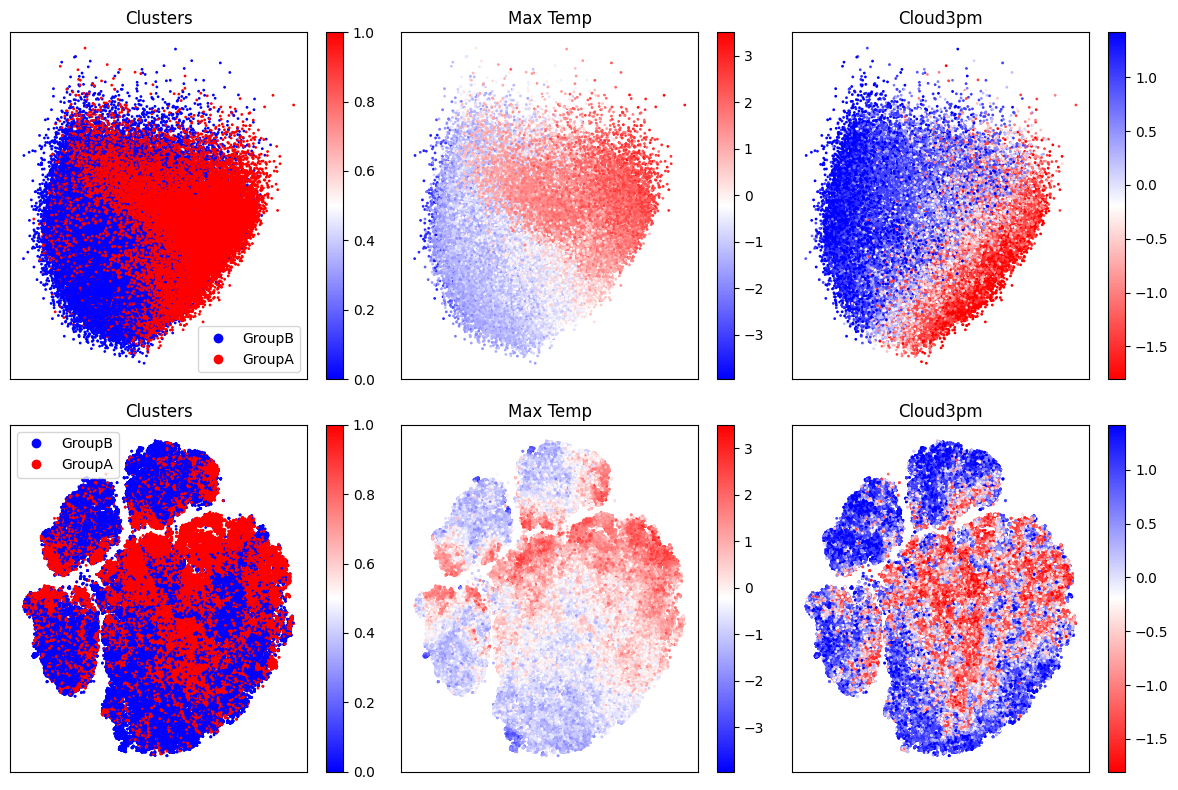

In [60]:
fig, ax = plt.subplots(2, 3)
axs = fig.axes
fig.set_size_inches(12, 8)

sctr = axs[0].scatter(X, Y, c=prepared_data['Nearest']==0, s=1, cmap='bwr')
axs[0].set_title('Clusters')
axs[0].legend(handles=sctr.legend_elements()[0], labels=['GroupB', 'GroupA'])
plt.colorbar(sctr)

sctr = axs[1].scatter(X, Y, c=prepared_std_data['MaxTemp'], s=1, cmap='bwr')
axs[1].set_title('Max Temp')
plt.colorbar(sctr)

sctr = axs[2].scatter(X, Y, c=prepared_std_data['Cloud3pm'], s=1, cmap='bwr_r')
axs[2].set_title('Cloud3pm')
plt.colorbar(sctr)

sctr = axs[3].scatter(*tsne_fit.T, c=prepared_data['Nearest']==0, s=1, cmap='bwr')
axs[3].set_title('Clusters')
axs[3].legend(handles=sctr.legend_elements()[0], labels=['GroupB', 'GroupA'])
plt.colorbar(sctr)

sctr = axs[4].scatter(*tsne_fit.T, c=prepared_std_data['MaxTemp'], s=1, cmap='bwr')
axs[4].set_title('Max Temp')
plt.colorbar(sctr)

sctr = axs[5].scatter(*tsne_fit.T, c=prepared_std_data['Cloud3pm'], s=1, cmap='bwr_r')
axs[5].set_title('Cloud3pm')
plt.colorbar(sctr)

for a in axs:
    a.tick_params(axis='both', labelbottom=False, labelleft=False, bottom=False, left=False)

plt.tight_layout()
plt.show()

We can see clear correlation between cluster assignment and max temperature, as expected. Other features have a similar, but less pronounced correlation, such as cloud coverage in the afternoon.

### Conclusion

In this project unsupervised clustering and dimensionality reduction algorithms were used to explore Australian weather data and reveal relationships between observations.

The KMeans algorithm was used to cluster the weather stations by their weather patterns, resulting in a North-South divide with strong correlations to the maximum daily temperature. 

Between the dimensionality reduction algorithms Principle Component Analysis (PCA) and t-Distributed Stochastic Neighbor Embedding (TSNE) it was found that the more complex, non-linear embedding performed by TSNE better captured the structure of the data while translating to lower dimensions. PCA lost most of the available information during the transformation, but still produced plots that could be used to compare relationships between features. Since TSNE is a much slower algorithm, this results in a tradeoff between processing time and embedded feature fidelity.

Future analysis could make use of the weather station clusters to train specialized models per cluster for weather prediction rather than relying on a single "global" model. Additional clustering methods and clustering on other features may also provide useful insights into the datasets. Similarity analysis might be a viable unsupervised learning method to produce weather predictions given the strong correlations between many features.

All code is available at my GitHub: https://github.com/nhansendev/DTSA5510_Final


### References
[1] Geoscience Australia. (2023, June 7). Climatic extremes. https://www.ga.gov.au/scientific-topics/national-location-information/dimensions/climatic-extremes 

[2] Evaporation : Gridded average monthly and annual evaporation (class A pan) (Base Climatological Data Set, 1975-2005). Evaporation : Gridded Average monthly and annual Evaporation (Class A Pan) (base climatological data set, 1975-2005) | Bureau Data Catalogue. (n.d.). http://www.bom.gov.au/metadata/catalogue/19115/ANZCW0503900362#distribution-information 

[3] Sunshine: Average daily sunshine hours. Water and the Land: Sunshine. (n.d.). http://www.bom.gov.au/watl/sunshine/ 

[4] Australian Government - Bureau of Meteorology. (n.d.). Average monthly wind velocity. Average monthly wind velocity maps, Bureau of Meteorology. http://www.bom.gov.au/climate/maps/averages/wind-velocity/ 

[5] Geoscience Australia. (2023, September 12). Tropical Cyclone & Severe wind. https://www.ga.gov.au/education/natural-hazards/tropical-cyclone-and-severe-wind 

[6] Pressure: 4 Day Forecast Chart. Water and the Land: Pressure. (n.d.). http://www.bom.gov.au/watl/pressure/index.shtml 

[7] Wikimedia Foundation. (2024, January 27). Okta. Wikipedia. https://en.wikipedia.org/wiki/Okta 

[8] Climate statistics for Australian locations. Climate Data Online - definition of 9 am and 3 pm climate statistics. (n.d.). http://www.bom.gov.au/climate/cdo/about/definitions9and3.shtml 

[9] Erdem, K. (2022, July 21). T-SNE clearly explained. Medium. https://towardsdatascience.com/t-sne-clearly-explained-d84c537f53a 